# COMP90051 Project 2

**Copyright statement:** This notebook is copyright University of Melbourne. 
It is licensed for the sole purpose of your assessment in COMP90051. 
You are not permitted to share or publish derived versions of this notebook, other than with COMP90051 staff for assessment.

***

The code block below imports the namespaces/functions/classes you may use in the project. 
Additional imports are not permitted.

In [1]:
# Do not edit. These are the only imports permitted.
import numpy as np
from abc import ABC, abstractmethod

# Type annotations
from numpy import ndarray
from numpy.random import Generator
from typing import List, Deque, Optional, Tuple

from sklearn.cluster import KMeans                   # for Task 3
from sklearn.linear_model import LogisticRegression  # for Task 4
from collections import deque                        # for Task 5
from scipy.stats import multivariate_normal          # for Task 5
import matplotlib.pyplot as plt                      # for Task 6

The base `MAB` class below defines a common interface for a contextual multi-armed bandit. 
Your bandit implementations in Tasks 1-4 should inherit from this class.

In [2]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.
        
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, rng: Optional[Generator] = None) -> None:
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms
        self.rng = np.random.default_rng(rng)
        
    @abstractmethod
    def play(self, context: ndarray) -> int:
        """Play a round
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th 
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.
        
        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set 
            {0, ..., n_arms - 1}.
        """
        
    @abstractmethod
    def update(self, arm: int, context: ndarray, 
               reward: Optional[float] = None) -> None:
        """Update the internal state of the MAB after a play
        
        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.
        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The 
            0-th axis indexes the arms, and the 1-st axis indexes the 
            features. Non-contextual bandits accept a context of None.
            
        reward : float, optional
            Reward received from the arm. If None, the reward is missing.
        """
        if arm >= self.n_arms or arm < 0:
            raise ValueError("`arm` must be in the range "
                             "[0, {}]".format(self.n_arms - 1))

The function below implements off-policy evaluation as described in Appendix A of the project spec. 
You should use it—along with the provided dataset—to evaluate the bandits in Tasks 1-4.

In [3]:
def offline_eval(mab: MAB, arms: ndarray, rewards: ndarray, contexts: ndarray, 
                 n_rounds: Optional[int] = None) -> ndarray:
    """Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.
    
    arms : int ndarray, shape (n_events,) 
        Array containing the history of pulled arms, represented as integer 
        indices in the set {0, ..., mab.n_arms}
    
    rewards : float ndarray, shape (n_events,)
        Array containing the history of rewards. If a reward is missing, it 
        should be represented by `np.nan`.
    
    contexts : float ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms. 
        The 0-th axis indexes the events in the history, the 1-st axis 
        indexes the arms and the 2-nd axis indexed the features.
        
    n_rounds : int, optional
        Number of matching events to evaluate the MAB on. If None, 
        continue evaluating until the historical events are exhausted.
    
    Returns
    -------
    matching_rewards : ndarray
        Rewards of matched events.
    
    matching_ids : ndarray
        Indices of matched events.
    """
    # Check types
    if not isinstance(mab, MAB):
        raise TypeError("`mab` must be an instance of MAB")
    arms = np.asarray(arms)
    rewards = np.asarray(rewards)
    contexts = np.asarray(contexts)
    if n_rounds is not None and n_rounds < 0:
        raise ValueError("`n_rounds` must be non-negative")
    
    # Check array dimensions
    if arms.ndim != 1:
        raise ValueError("`arms` must be a 1D array")
    if rewards.ndim != 1:
        raise ValueError("`rewards` must be a 1D array")
    if contexts.ndim != 3:
        raise ValueError("`contexts` must be a 3D array")
    if not (arms.shape[0] == rewards.shape[0] == contexts.shape[0]):
        raise ValueError("first dimension of input arrays are inconsistent")
    if contexts.shape[1] != mab.n_arms:
        raise ValueError("`contexts` has inconsistent second dimension")
    if arms.max() >= mab.n_arms or arms.min() < 0:
        raise ValueError("`arms` contains ids that are out-of-range")
  
    
    matched_ctr = 0
    matched_ids = list()
    for i in range(arms.size):
        if matched_ctr >= n_rounds:#finish n_round matches
            break
        arm_id = mab.play(contexts[i])
        if arm_id == arms[i]:
            reward = None if np.isnan(rewards[i]) else rewards[i]
            mab.update(arm_id, contexts[i], reward)
            matched_ctr += 1
            matched_ids.append(i)
            
    matched_ids = np.array(matched_ids)
    return rewards[matched_ids], matched_ids

Please define any static functions/variables (used across multiple tasks) in the code block below.

In [4]:
rng = np.random.default_rng(90051)  # Random generator used throughout

# Define additional static functions/variables here, if required
from numpy.linalg import inv
from random import choices

def getCumulativeReward(ids):
    n_rounds_record = 0
    cumulative_reward = 0# record the n th round cumulative reward
    sum_reward = []# record each round cumulative reward
    for i in ids:
        #cumulative reward till this round
        cumulative_reward +=rewards[i]
        sum_reward.append(cumulative_reward)
        n_rounds_record +=1
    return sum_reward

## Task 1: Implement LinUCB

### 1.1   implement LinUCB 

In [5]:
class LinUCB(MAB):
    """LinUCB

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, n_dims: int, alpha: float, 
                 rng: Optional[Generator] = None) -> None:
        super().__init__(n_arms,rng)
        self.n_dims = n_dims
        self.alpha = alpha
        # A[arm] is a n_dims x n_dims identity matrix
        self.A = np.zeros((self.n_arms,self.n_dims,self.n_dims))
        for arm  in range (self.n_arms):
            self.A[arm] = np.identity(n_dims)
        # b[arm] vector is n_dims x 1
        self.b = np.zeros((self.n_arms,self.n_dims,1))
        # at rount t
        self.t = 0 
        return 
    def play(self, context: ndarray) -> int:
        #
        self.t = self.t+1
        p_t = np.zeros(self.n_dims)
        
        for arm in range(self.n_arms):
            #follow the formula 
            theta = inv(self.A[arm]).dot(self.b[arm])
            p_t[arm] = theta.T.dot(context[arm]) + self.alpha * np.sqrt(context[arm].T.dot(inv(self.A[arm]).dot(context[arm])))
        chosen_arm = np.argmax(p_t)# choose the arm with max p_t, argmax return the index of this value,which
        #is the same with the order of arm
        
        return chosen_arm
    
    def update(self, arm: int, context: ndarray, 
               reward: Optional[float] = None) -> None:        
        if reward is not None:
            self.b[arm] = (self.b[arm].T +context[arm]*reward).reshape(self.n_dims,1)
        self.A[arm] = self.A[arm] + np.outer(context[arm],context[arm])
        # i try the np.dot(context[arm],context[arm].T) get a number, so i thought what we really need to add
        #  to A[arm] is also a n_dim x n_dim matrix ,so i use np.outer to form a matrix. That improves the performance
        # of the my result. But i am not very certain about that
        return
    

In [6]:
# Load dataset here
data = np.loadtxt('./dataset.txt')
arms = data[:,0]
rewards = data[:,1]
rewards_missing = data[:,2]
col_4to103 = np.asarray(data[:,3:103])
n_instances = col_4to103.shape[0]#number of instances :10000
n_features = col_4to103.shape[1]#number of features of 100
number_of_arms =10
number_of_dims =10 
contexts = col_4to103.reshape(n_instances,number_of_arms,number_of_dims)#contexts shape: (10000,10,10)

In [7]:
mab = LinUCB(10, 10, 1.0, rng)
LinUCB_rewards_1, LinUCB_rewards_1_ids = offline_eval(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(rewards[LinUCB_rewards_1_ids]))

LinUCB average reward 0.53


### 1.2   Draw LinUCB figure for per-round cumulative rewards

In [8]:
# Use additional cells here for experimentation
cumulative_LinUCB_rewards_1= np.asarray(getCumulativeReward(LinUCB_rewards_1_ids))

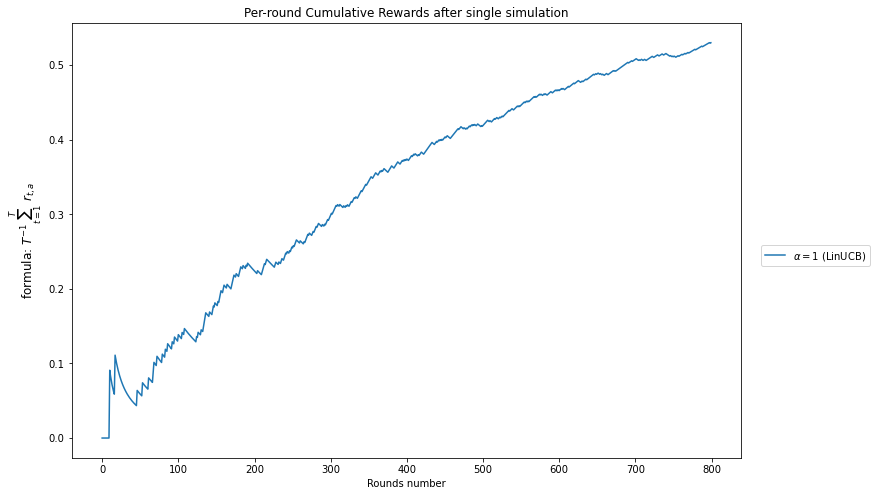

In [9]:
plt.figure(figsize=(12,8))
plt.plot(cumulative_LinUCB_rewards_1/np.linspace(1,800,800), label = r"$\alpha=1$ (LinUCB)")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Rounds number")
plt.ylabel("formula: $T^{-1}\sum_{t=1}^T\ r_{t,a}$", fontsize='large')
plt.title("Per-round Cumulative Rewards after single simulation")
plt.show()

### 1.3.1   grid research for parameter alpha for LinUCB

In [10]:
best_score = 0
LinUCB_scores = []
candidate_alpha = list(np.arange(0.001,0.100,0.001))
print("LinUCB tuning parameter alpha")
print("=============================")
for alpha in candidate_alpha:
    mab = LinUCB(10, 10, alpha, rng)
    LinUCB_rewards, chosen_ids = offline_eval(mab, arms, rewards, contexts, 800)
    score = np.mean(rewards[chosen_ids])
    LinUCB_scores.append(score)
    if score > best_score:
        best_score = score
        LinUCB_rewards_best_ids = chosen_ids
        best_parameters = {'alpha':alpha}
    print("alpha:  %.3f  =>  score:  %.2f,  best score till now:  %.2f" %(alpha,score,best_score))
print("=============================")
print("LinUCB Best score:{:.2f}".format(best_score))
print("LinUCB Best parameters:{}".format(best_parameters))

LinUCB tuning parameter alpha
alpha:  0.001  =>  score:  0.72,  best score till now:  0.72
alpha:  0.002  =>  score:  0.72,  best score till now:  0.72
alpha:  0.003  =>  score:  0.73,  best score till now:  0.73
alpha:  0.004  =>  score:  0.73,  best score till now:  0.73
alpha:  0.005  =>  score:  0.66,  best score till now:  0.73
alpha:  0.006  =>  score:  0.65,  best score till now:  0.73
alpha:  0.007  =>  score:  0.66,  best score till now:  0.73
alpha:  0.008  =>  score:  0.72,  best score till now:  0.73
alpha:  0.009  =>  score:  0.73,  best score till now:  0.73
alpha:  0.010  =>  score:  0.73,  best score till now:  0.73
alpha:  0.011  =>  score:  0.73,  best score till now:  0.73
alpha:  0.012  =>  score:  0.72,  best score till now:  0.73
alpha:  0.013  =>  score:  0.72,  best score till now:  0.73
alpha:  0.014  =>  score:  0.74,  best score till now:  0.74
alpha:  0.015  =>  score:  0.73,  best score till now:  0.74
alpha:  0.016  =>  score:  0.73,  best score till now: 

### 1.3.2   per round cumulative rewards figure  parameter: alpha for LinUCB

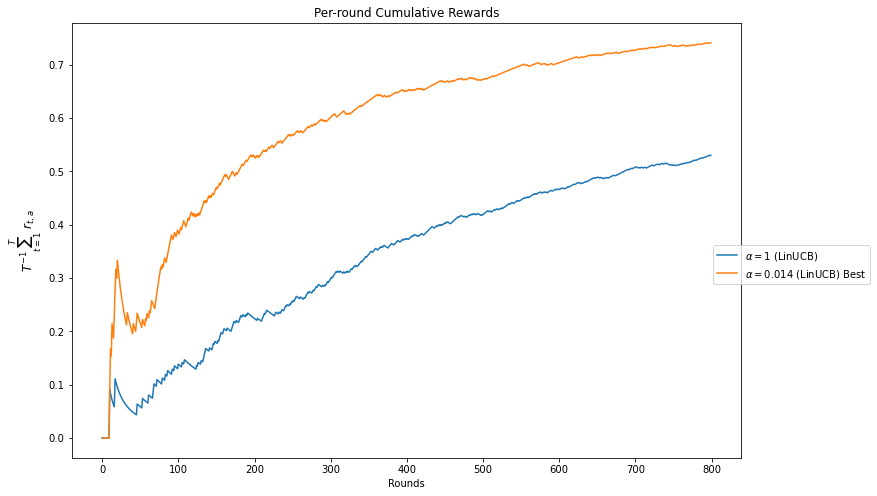

In [11]:
best_alpha_LinUCB = best_parameters['alpha']
cumulative_LinUCB_rewards_best= np.asarray(getCumulativeReward(LinUCB_rewards_best_ids))

#Plot the figure
plt.figure(figsize=(12,8))
plt.plot(cumulative_LinUCB_rewards_1/np.linspace(1,800,800), label = r"$\alpha=1$ (LinUCB)")
plt.plot(cumulative_LinUCB_rewards_best/np.linspace(1,800,800), label = r"$\alpha=%.3f$ (LinUCB) Best" %(best_alpha_LinUCB))
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Rounds")
plt.ylabel(r"$T^{-1}\sum_{t=1}^T\ r_{t,a}$", fontsize='large')
plt.title("Per-round Cumulative Rewards")
plt.show()

## Task 2: Implement MLinUCB

### 2.1   implement MLinUCB

In [12]:
class MLinUCB(MAB):
    """MLinUCB

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    
    N : int
        Number of clusters
        
    m : int
        Number of closest clusters to use when imputing the reward.
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, n_dims: int, alpha: float, N: int, m: int, 
                 rng: Optional[Generator] = None) -> None:
        super().__init__(n_arms,rng)
        self.n_dims = n_dims
        self.alpha = alpha
        self.N = N
        self.m = m
        #to record reward
        self.r = np.zeros(n_instances)#10000 instances
        #number of instance at t round
        self.s = 0
        # A[arm] : n_dims x n_dims identitymatrix
        self.A = np.zeros((self.n_arms,self.n_dims,self.n_dims))
        # b[arm] is the vecter, each arm has  n_dims x 1 vector
        self.b = np.zeros((self.n_arms,self.n_dims,1))
        #set to A0,b0
        for arm in range(n_arms):
            self.A[arm] = np.identity(n_dims)
            #self.b[arm] = self.b[0]
        #to record the cluster and kmeans center
        self.clusters_prediction = [] 
        self.kmeans_centers = []
        self.nubmerOfCluster = 0
        return 
    
    def play(self, context: ndarray) -> int:
        #update the x_s intances contexts to t round,
        self.s = self.s +1
        #initial p_t as zero
        p_t = np.zeros(self.n_arms)      
        for arm in range(self.n_arms):
            # initialize theta 
            self.theta = inv(self.A[arm]).dot(self.b[arm])
            #print(self.theta.shape)
            p_t[arm] = self.theta.T.dot(context[arm]) + self.alpha * np.sqrt(context[arm].T.dot(inv(self.A[arm]).dot(context[arm])))
        chosen_arm = np.argmax(p_t)
        return chosen_arm
    
    
    def update(self, arm: int, context: ndarray, 
               reward: Optional[float] = None) -> None:
        if reward is not None:#reward is available
            rt = reward
        else:#reward is missing
            self.clusters_prediction, self.kmeans_centers = self.getClusterPrediction(self.s)
            rt,m_prime =  self.update_M_prime_reward(context)
            
        self.A[arm] = self.A[arm] + np.outer(context[arm],context[arm])
        self.b[arm] = np.add(self.b[arm].T, context[arm]*rt).reshape(self.n_dims,1)
        return
    
    def getClusterPrediction(self, n:int):
        #number of this instance: n th
        #each time use the intances till s th round to classify the clusters
        X_s= np.asarray(data[:n,3:103])
        
        # cluster {x1...xs} into min{s,N}
        self.nubmerOfCluster = min(self.s,self.N)
        # model is kmeans
        kmeans = KMeans(n_clusters=self.nubmerOfCluster, random_state=0).fit(X_s)
        
        #prediction the cluster number in the form of array
        clusters_prediction = kmeans.predict(X_s)
        
        return clusters_prediction,kmeans.cluster_centers_
    
    def update_M_prime_reward(self,context):
        # r records all the original rewards till sth instances
        r = np.zeros(self.s)
        for i in range(self.s):
            if np.isnan(rewards_missing[i]) :
                r[i] = 0
            else:
                r[i] = rewards_missing[i]
                
        #update m_prime
        m_prime = min(self.s,self.m)
        
        #initial r_bar[] and d[]
        r_bar = np.zeros(self.nubmerOfCluster)
        d = np.zeros(self.nubmerOfCluster)
        
        #calculate r_bar[] and d[] for each cluster
        #number_of_cluster:min(s,self.N) 
        for j in range(self.nubmerOfCluster):# j th cluster
            n = 0 # initial number of point as 0
            reward_sum_j_cluster = 0 #initial sum of reward as 0
            d_array = []
            for i in range(self.s):
                if self.clusters_prediction[i] == j:
                    n = n+1 # number of point +1
                    reward_sum_j_cluster  += r[i]

                    #find this
                    x_t= context.flatten()
                    d_array.append(np.linalg.norm(x_t-self.kmeans_centers[j]))
            if n == 0:
                r_bar[j] = 0
                d[j] = 0
            else:
                r_bar[j] = reward_sum_j_cluster /n
                ascending_d = np.sort(d_array)
                d[j] = ascending_d[0]
        
        #calculate gxt formula
        sum_down = 0# formula at lower side
        sum_up = 0# formula at upper side
        for i in range(m_prime):#m_prime is the number of closet clusters centers we need to add 
            #print(i,len(r_bar[]),len(d))
            sum_up += r_bar[i]/(0.1 + d[i])
            sum_down += 1/(0.1 + d[i])
        gxt = sum_up/sum_down
        reward = gxt
        return reward,m_prime

if m > N , the model cannot run. e.g. if (m = 2, N=1) we cumulate 2 clusters generated averager rewards,but we only generate 1 cluster 

In [13]:
# Define rewards_missing here - the rewards array from above where missing values are represented as np.nan
def getMissingReward(reward_data,missing_data):
    reward = np.asarray(reward_data)
    missing =  np.asarray(missing_data)

    missing_rewards=[]
    for i in range(n_instances):
        if missing[i] != 0.0:
            missing_rewards.append(reward[i])
        else:
            missing_rewards.append(float('nan'))
    #missing_rewards
    return missing_rewards
rewards_missing = getMissingReward(data[:,1],data[:,2])

In [14]:
mab = MLinUCB(10, 10, 1.0, 10, 3, rng)
MLinUCB_rewards_1_10_3_missing, MLinUCB_ids_1_10_3 = offline_eval(mab, arms, rewards_missing, contexts, 800)
print('MLinUCB average reward', np.mean(rewards[MLinUCB_ids_1_10_3]))

mab = LinUCB(10, 10, 1.0, rng)
LinUCB_rewards_1_missing, LinUCB_ids_1 = offline_eval(mab, arms, rewards_missing, contexts, 800)
print('LinUCB average reward', np.mean(rewards[LinUCB_ids_1]))

MLinUCB average reward 0.325
LinUCB average reward 0.33625


### 2.2   implement MLinCB per-round Cumulative Rewards with missing rewards

In [15]:
# Use additional cells here for experimentation

cumulative_MLinUCB_rewards_1_10_3_missing= np.asarray(getCumulativeReward(MLinUCB_ids_1_10_3))
cumulative_LinUCB_rewards_1_missing= np.asarray(getCumulativeReward(LinUCB_ids_1))

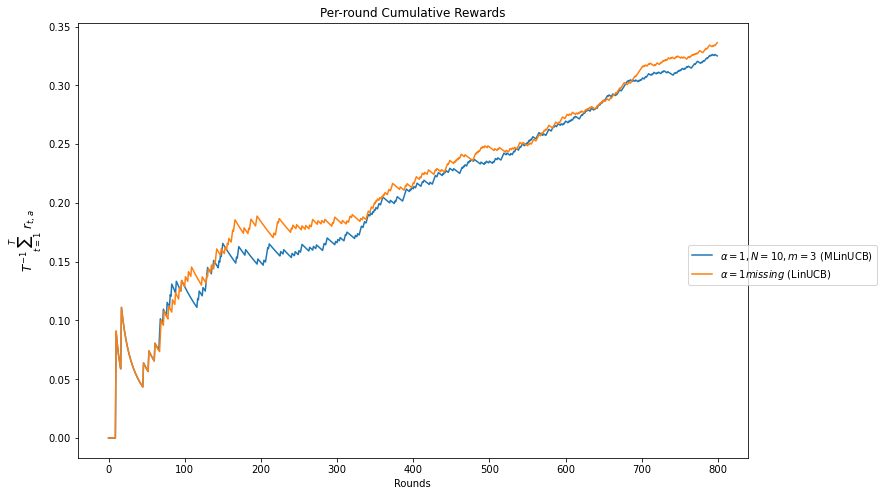

In [16]:
plt.figure(figsize=(12,8))
plt.plot(cumulative_MLinUCB_rewards_1_10_3_missing/np.linspace(1,800,800), label = r"$\alpha=1,N=10,m=3$ (MLinUCB)")
plt.plot(cumulative_LinUCB_rewards_1_missing/np.linspace(1,800,800), label = r"$\alpha=1 missing$ (LinUCB)")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Rounds")
plt.ylabel(r"$T^{-1}\sum_{t=1}^T\ r_{t,a}$", fontsize='large')
plt.title("Per-round Cumulative Rewards")
plt.show()

### 2.3.1   grid research for parameter alpha,N,m for MLinCB 

In [17]:
best_score = 0

candidate_alpha2 = list(np.arange(0.01,0.05,0.01))
candidate_m = list(np.arange(1,6,1))
candidate_N = list(np.arange(1,6,1))
MLinUCB_scores = []
print("MLinUCB tuning parameter: alpha,m,N")
print("=============================")
for m in candidate_m:
    for N in candidate_N:
        if(m<=N):
            for alpha in candidate_alpha2:
                    mab = MLinUCB(10, 10, alpha, N, m, rng)
                    MLinUCB_rewards, MLinUCB_ids  = offline_eval(
                mab, arms, rewards_missing, contexts, 800)
                    score = np.mean(rewards[MLinUCB_ids])
                    MLinUCB_scores.append(score)
                    if score > best_score:
                        best_score = score
                        MLinUCB_ids_best = MLinUCB_ids
                        best_parameters_MlinUCB = {'alpha':alpha,'N':N,'m':m}
                    print("alpha : %.2f, m : %.f, N : %.f  =>  score: %.2f,  best score till now:  %.2f"%(
                        alpha,m,N,score,best_score)) 

print("=============================")
print("MlinUCB Best score:{:.2f}".format(best_score))
print("MlinUCB Best parameters:{}".format(best_parameters_MlinUCB))


MLinUCB tuning parameter: alpha,m,N
alpha : 0.01, m : 1, N : 1  =>  score: 0.49,  best score till now:  0.49
alpha : 0.02, m : 1, N : 1  =>  score: 0.62,  best score till now:  0.62
alpha : 0.03, m : 1, N : 1  =>  score: 0.64,  best score till now:  0.64
alpha : 0.04, m : 1, N : 1  =>  score: 0.60,  best score till now:  0.64
alpha : 0.01, m : 1, N : 2  =>  score: 0.45,  best score till now:  0.64
alpha : 0.02, m : 1, N : 2  =>  score: 0.60,  best score till now:  0.64
alpha : 0.03, m : 1, N : 2  =>  score: 0.61,  best score till now:  0.64
alpha : 0.04, m : 1, N : 2  =>  score: 0.60,  best score till now:  0.64
alpha : 0.01, m : 1, N : 3  =>  score: 0.47,  best score till now:  0.64
alpha : 0.02, m : 1, N : 3  =>  score: 0.63,  best score till now:  0.64
alpha : 0.03, m : 1, N : 3  =>  score: 0.65,  best score till now:  0.65
alpha : 0.04, m : 1, N : 3  =>  score: 0.62,  best score till now:  0.65
alpha : 0.01, m : 1, N : 4  =>  score: 0.64,  best score till now:  0.65
alpha : 0.02, m

In [18]:
best_m = best_parameters_MlinUCB['m']
best_N = best_parameters_MlinUCB['N']
best_alpha_Mlin = best_parameters_MlinUCB['alpha']

cumulative_MLinUCB_rewards_best= np.asarray(getCumulativeReward(MLinUCB_ids_best))

### 2.3.2   figure with tuned parameter alpha,N,m for MLinCB 

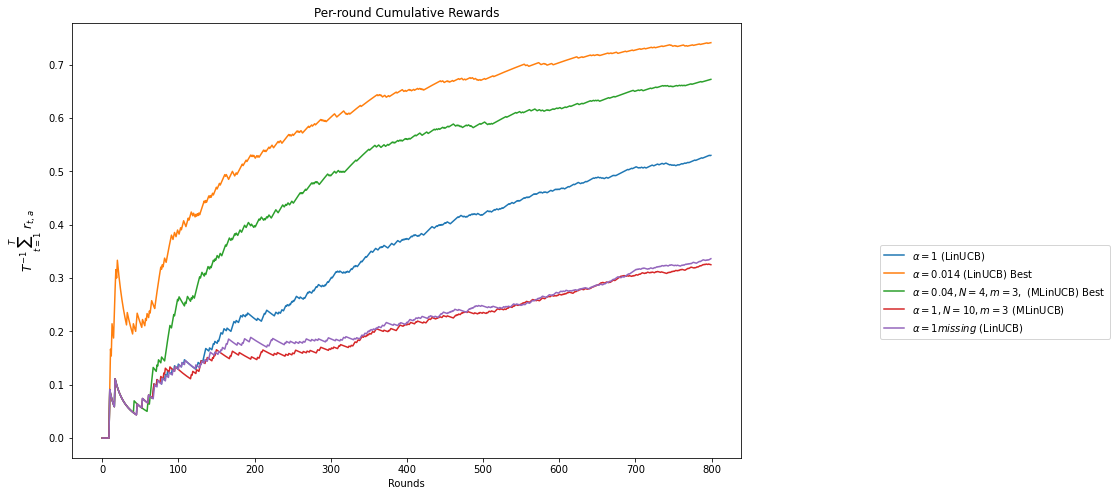

In [19]:
plt.figure(figsize=(12,8))
plt.plot(cumulative_LinUCB_rewards_1/np.linspace(1,800,800), label = r"$\alpha=1$ (LinUCB)")
plt.plot(cumulative_LinUCB_rewards_best/np.linspace(1,800,800), label = r"$\alpha=%.3f$ (LinUCB) Best" %(best_alpha_LinUCB))
plt.plot(cumulative_MLinUCB_rewards_best/np.linspace(1,800,800), label = r"$\alpha=%.2f,N=%.f,m=%.f,$ (MLinUCB) Best" %(best_alpha_Mlin,best_N,best_m))
plt.plot(cumulative_MLinUCB_rewards_1_10_3_missing/np.linspace(1,800,800), label = r"$\alpha=1,N=10,m=3$ (MLinUCB)")
plt.plot(cumulative_LinUCB_rewards_1_missing/np.linspace(1,800,800), label = r"$\alpha=1 missing$ (LinUCB)")

plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Rounds")
plt.ylabel(r"$T^{-1}\sum_{t=1}^T\ r_{t,a}$", fontsize='large')
plt.title("Per-round Cumulative Rewards")
plt.show()

## Task 3: Implement SquareCB

### 3.1   implement SquareCB 

In [20]:

class SquareCB(MAB):
    """SquareCB with a logistic regression oracle

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.
    
    gamma : float
        Learning rate parameter.
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, n_dims: int, gamma: float, 
                 rng: Optional[Generator] = None) -> None:
        super().__init__(n_arms,rng)
        self.n_dims = n_dims
        self.gamma = gamma
        #initial per arm has X for contexts, X[arm] = []
        self.X = [[] for i in range(self.n_arms)]
        #initial per arm has y for loss
        self.y =[[] for i in range(self.n_arms)]
        #initial t round as 0
        self.t = 0
        #initial all arms has not be used 
        self.existed_arms = [False]*10
        #initial the array for cases the first time this arm don't have sqAlg score
        self.SqAlg0 = [np.random.uniform(0,1) for i in range(10)]
        
        self.miu = n_arms
    
    def play(self, context: ndarray) -> int:
        self.t = self.t +1

        scores = np.zeros(self.n_arms)
        for i in range(self.n_arms):
            scores[i] = self.get_SqAlg_score(context,i)
        b_t_index = np.argmin(scores)
        b_t = scores[b_t_index]
            
        sum_p_t_a = 0
        p_t = np.zeros(self.n_arms)
        for arm in range(self.n_arms):
            if arm != b_t_index: 
                p_t[arm] = 1/(self.miu + self.gamma*(scores[arm]-b_t))
                sum_p_t_a += p_t[arm]
                    
        p_t[b_t_index] = 1-sum_p_t_a#weight
        population = np.arange(self.n_arms)#population
        a_t = choices(population, p_t)[0] # sample a_t from distribuiton
        
        return a_t
           
    
    def update(self, arm: int, context: ndarray, 
               reward: Optional[float] = None) -> None:
        
        if self.existed_arms[arm] == False:
            self.X[arm].append(context.flatten())
            self.y[arm].append(-reward)
            # the reason why i want to add a differ loss with this instance is
            # logistic regression have to work with at least 2 classes, so i manually create the
            # the opposite reward with first intances(ONLY for 1st instance each arm)
            self.X[arm].append(context.flatten())
            self.y[arm].append(-(1-reward))
            self.existed_arms[arm] = True
        
        self.X[arm].append(context.flatten())
        self.y[arm].append(-reward)
        return
    
    
    def get_SqAlg_score(self,context,arm):
        if self.existed_arms[arm] == False:
            return self.SqAlg0[arm]
        else:
            X_arm = np.asarray(self.X[arm])
            y_arm = np.asarray(self.y[arm])
            
            clf = LogisticRegression(random_state=0,solver='lbfgs', max_iter=500,n_jobs=-1).fit(X_arm, y_arm)
            X_test = np.asarray(context.flatten()).reshape(1,100)
            y = clf.predict(X_test)[0]
                
            return y


In [21]:
mab = SquareCB(10, 10, 18.0, rng)
SquareCB_rewards_18, SquareCB_rewards_18_ids = offline_eval(mab, arms, rewards, contexts, 800)
print('SquareCB average reward', np.mean(rewards[SquareCB_rewards_18_ids]))

SquareCB average reward 0.55875


### 3.2   implement SquareCB per-round Cumulative Rewards

<Figure size 864x576 with 0 Axes>

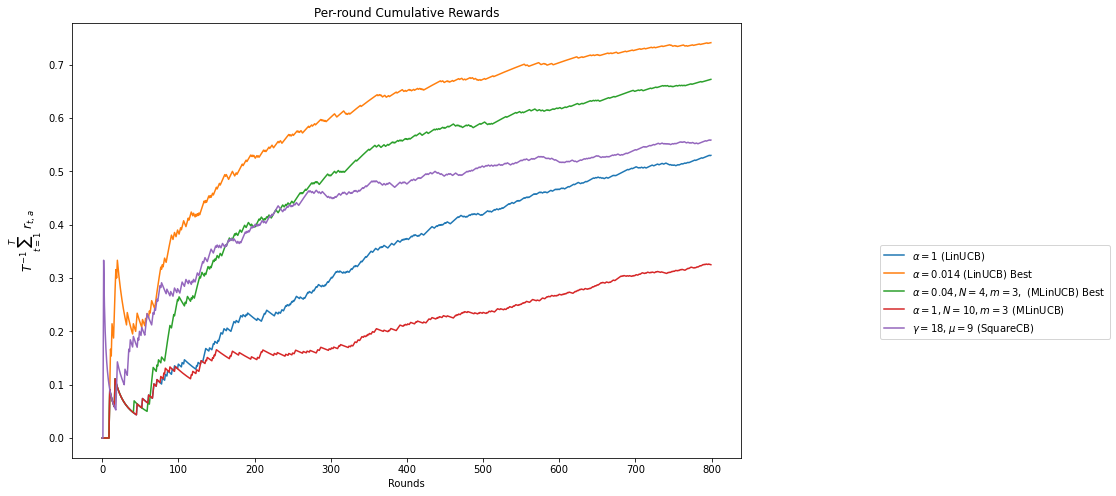

In [22]:
# Use additional cells here for experimentation

cumulative_SquareCB_rewards_1= np.asarray(getCumulativeReward(SquareCB_rewards_18_ids))
plt.figure(figsize=(12,8))
plt.figure(figsize=(12,8))
plt.plot(cumulative_LinUCB_rewards_1/np.linspace(1,800,800), label = r"$\alpha=1$ (LinUCB)")
plt.plot(cumulative_LinUCB_rewards_best/np.linspace(1,800,800), label = r"$\alpha=%.3f$ (LinUCB) Best" %(best_alpha_LinUCB))
plt.plot(cumulative_MLinUCB_rewards_best/np.linspace(1,800,800), label = r"$\alpha=%.2f,N=%.f,m=%.f,$ (MLinUCB) Best" %(best_alpha_Mlin,best_N,best_m))
plt.plot(cumulative_MLinUCB_rewards_1_10_3_missing/np.linspace(1,800,800), label = r"$\alpha=1,N=10,m=3$ (MLinUCB)")
#plt.plot(cumulative_LinUCB_rewards_1_missing/np.linspace(1,800,800), label = r"$\alpha=1 missing$ (LinUCB)")
plt.plot(cumulative_SquareCB_rewards_1/np.linspace(1,800,800), label = r"$\gamma=18,\mu=9$ (SquareCB)")

plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Rounds")
plt.ylabel(r"$T^{-1}\sum_{t=1}^T\ r_{t,a}$", fontsize='large')
plt.title("Per-round Cumulative Rewards")
plt.show()

### 3.3.1   grid research for gamma

In [23]:
candidate_gamma = list(np.arange(100,1800,100))

best_score = 0
print("SquareCB tuning parameter gamma")
print("=============================")
for gamma in candidate_gamma:
        mab = SquareCB(10, 10, gamma, rng)
        SquareCB_rewards, chosen_ids = offline_eval(
    mab, arms, rewards, contexts, 800)
        score = np.mean(rewards[chosen_ids])
        if score > best_score:
            #print("gamma: ", gamma, "score",score)
            best_score = score
            SquareCB_rewards_best_ids = chosen_ids
            best_parameters_SquareCB = {'gamma':gamma}
        print("gamma:  %.f  =>  score:  %.2f,  best score till now:  %.2f" %(gamma,score,best_score))
print("=============================")
print("SquareCB Best score:{:.2f}".format(best_score))
print("SquareCB Best parameters:{}".format(best_parameters_SquareCB))
best_gamma = best_parameters_SquareCB['gamma']

SquareCB tuning parameter gamma
gamma:  100  =>  score:  0.74,  best score till now:  0.74
gamma:  200  =>  score:  0.78,  best score till now:  0.78
gamma:  300  =>  score:  0.72,  best score till now:  0.78
gamma:  400  =>  score:  0.64,  best score till now:  0.78
gamma:  500  =>  score:  0.84,  best score till now:  0.84
gamma:  600  =>  score:  0.59,  best score till now:  0.84
gamma:  700  =>  score:  0.62,  best score till now:  0.84
gamma:  800  =>  score:  0.31,  best score till now:  0.84
gamma:  900  =>  score:  0.28,  best score till now:  0.84
gamma:  1000  =>  score:  0.55,  best score till now:  0.84
gamma:  1100  =>  score:  0.52,  best score till now:  0.84
gamma:  1200  =>  score:  0.45,  best score till now:  0.84
gamma:  1300  =>  score:  0.54,  best score till now:  0.84
gamma:  1400  =>  score:  0.28,  best score till now:  0.84
gamma:  1500  =>  score:  0.70,  best score till now:  0.84
gamma:  1600  =>  score:  0.42,  best score till now:  0.84
gamma:  1700  => 

In [24]:
cumulative_SquareCB_rewards_best= np.asarray(getCumulativeReward(SquareCB_rewards_best_ids))

### 3.3.2 all result with figure(with tuned parameter)

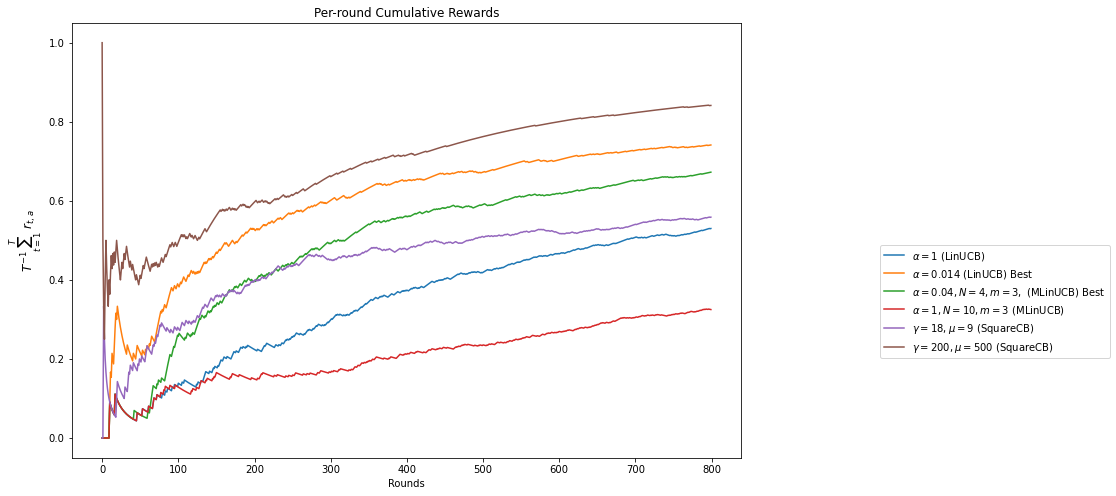

In [25]:
plt.figure(figsize=(12,8))
plt.plot(cumulative_LinUCB_rewards_1/np.linspace(1,800,800), label = r"$\alpha=1$ (LinUCB)")
plt.plot(cumulative_LinUCB_rewards_best/np.linspace(1,800,800), label = r"$\alpha=%.3f$ (LinUCB) Best" %(best_alpha_LinUCB))
plt.plot(cumulative_MLinUCB_rewards_best/np.linspace(1,800,800), label = r"$\alpha=%.2f,N=%.f,m=%.f,$ (MLinUCB) Best" %(best_alpha_Mlin,best_N,best_m))
plt.plot(cumulative_MLinUCB_rewards_1_10_3_missing/np.linspace(1,800,800), label = r"$\alpha=1,N=10,m=3$ (MLinUCB)")
#plt.plot(cumulative_LinUCB_rewards_1_missing/np.linspace(1,800,800), label = r"$\alpha=1 missing$ (LinUCB)")
plt.plot(cumulative_SquareCB_rewards_1/np.linspace(1,800,800), label = r"$\gamma=18,\mu=9$ (SquareCB)")
plt.plot(cumulative_SquareCB_rewards_best/np.linspace(1,800,800), label = r"$\gamma=200,\mu=%.f$ (SquareCB)" %(best_gamma))
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Rounds")
plt.ylabel(r"$T^{-1}\sum_{t=1}^T\ r_{t,a}$", fontsize='large')
plt.title("Per-round Cumulative Rewards")
plt.show()